# Autotalker Tutorial

Created by Sebastian Birk (<sebastian.birk@helmholtz-munich.de>).

## 1. Setup

### 1.1 Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import argparse
import os
from datetime import datetime

import mlflow
import numpy as np
import scanpy as sc
import squidpy as sq
import torch

from autotalker.data import load_spatial_adata_from_csv
from autotalker.models import Autotalker
from autotalker.utils import (add_gps_from_gp_dict_to_adata,
                              extract_gp_dict_from_nichenet_ligand_target_mx,
                              extract_gp_dict_from_omnipath_lr_interactions)

### 1.2 Configure Paths and Create Directories

In [3]:
# Mlflow
os.makedirs("mlruns", exist_ok=True)

# Gene program data
gp_data_folder_path = "datasets/gp_data"
nichenet_ligand_target_mx_file_path = gp_data_folder_path + "/nichenet_ligand_target_matrix.csv"
omnipath_lr_interactions_file_path = gp_data_folder_path + "/omnipath_lr_interactions.csv"
os.makedirs(gp_data_folder_path, exist_ok=True)

### 1.3 Define Parameters

In [4]:
dataset = "squidpy_seqfish"
# node_label_method = "self"
node_label_method = "one-hop-norm"
# node_label_method = "one-hop-sum"
n_latent_fc_gps = 512
edge_batch_size = 32

## 2. Load Data

In [5]:
print(f"Using dataset {dataset}.")

if dataset == "deeplinc_seqfish":
    adata = load_spatial_adata_from_csv(counts_file_path="datasets/seqFISH/counts.csv",
                                        adj_file_path="datasets/seqFISH/adj.csv",
                                        cell_type_file_path="datasets/seqFISH/cell_types.csv",
                                        cell_type_col="Cell_class_name")
    cell_type_key = "cell_type"
elif dataset == "squidpy_seqfish":
    adata = sq.datasets.seqfish()
    sq.gr.spatial_neighbors(adata, radius = 0.04, coord_type="generic")
    cell_type_key = "celltype_mapped_refined"
elif dataset == "squidpy_slideseqv2":
    adata = sq.datasets.slideseqv2()
    sq.gr.spatial_neighbors(adata, radius = 30.0, coord_type="generic")
    cell_type_key = "cluster"
    
adata.layers["counts"] = adata.X.copy()

Using dataset squidpy_seqfish.


In [6]:
print(f"Number of nodes: {adata.layers['counts'].shape[0]}")
print(f"Number of node features: {adata.layers['counts'].shape[1]}")
avg_edges_per_node = round(
    adata.obsp['spatial_connectivities'].toarray().sum(axis=0).mean(),2)
print(f"Average number of edges per node: {avg_edges_per_node}")
n_edges = int(np.triu(adata.obsp['spatial_connectivities'].toarray()).sum())
print(f"Number of edges: {n_edges}", sep="")

Number of nodes: 19416
Number of node features: 351
Average number of edges per node: 4.4
Number of edges: 42694


## 3. Autotalker Model with Fully Connected Gene Programs

### 3.1 Create Fully Connected Gene Program Mask

In [8]:
# Mask that allows all genes
if node_label_method == "self":
    n_output = len(adata.var)
    gp_targets_mask = np.ones((n_latent_fc_gps, n_output))
    print(f"gp_targets_mask shape: {gp_targets_mask.shape}")
elif node_label_method != "self":
    n_output = len(adata.var) * 2
    gp_targets_mask = np.ones((n_latent_fc_gps, int(n_output / 2)))
    gp_sources_mask = np.ones((n_latent_fc_gps, int(n_output / 2)))
    print(f"gp_targets_mask shape: {gp_targets_mask.shape}.")
    print(f"gp_sources_mask shape: {gp_sources_mask.shape}.")

gp_targets_mask shape: (512, 351).
gp_sources_mask shape: (512, 351).


### 3.2 Initialize, Train & Save Model

In [9]:
model = Autotalker(adata,
                   counts_layer_key="counts",
                   adj_key="spatial_connectivities",
                   gp_targets_mask_key=None,
                   gp_sources_mask_key=None,
                   include_edge_recon_loss=True,
                   include_gene_expr_recon_loss=True,
                   log_variational=True,
                   node_label_method=node_label_method,
                   n_hidden_encoder=int(n_latent_fc_gps/2),
                   dropout_rate_encoder=0.,
                   dropout_rate_graph_decoder=0.,
                   gp_targets_mask=gp_targets_mask,
                   gp_sources_mask=(None if node_label_method == "self" else gp_sources_mask))

--- INITIALIZING NEW NETWORK MODULE: VGPGAE ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True
GCN ENCODER -> n_input: 351, n_hidden: 256, n_latent: 512, dropout_rate: 0.0
DOT PRODUCT GRAPH DECODER -> dropout_rate: 0.0
MASKED GENE EXPRESSION DECODER -> n_input: 512, n_output: 702


In [10]:
experiment = mlflow.set_experiment("autotalker_fc_gps")
mlflow.log_param("dataset", dataset)

model.train(n_epochs=30,
            lr=0.01,
            weight_decay=0,
            edge_val_ratio=0.1,
            edge_test_ratio=0.05,
            node_val_ratio=0.1,
            edge_batch_size=edge_batch_size,
            mlflow_experiment_id=experiment.experiment_id)

--- INITIALIZING TRAINER ---
Number of training nodes: 17474
Number of validation nodes: 1942
Number of training edges: 36291
Number of validation edges: 4269
Number of test edges: 2134

--- MODEL TRAINING ---
Epoch 1/30 |--------------------| 3.3% val_auroc_score: 0.9536; val_auprc_score: 0.9368; val_best_acc_score: 0.8960; val_best_f1_score: 0.9003; train_loss: 554.3483; train_edge_recon_loss: 1.1967; train_kl_loss: 0.7040; train_gene_expr_recon_loss: 552.4475; val_loss: 544.5068; val_edge_recon_loss: 0.5738; val_kl_loss: 0.7999; val_gene_expr_recon_loss: 543.1331
Epoch 2/30 |█-------------------| 6.7% val_auroc_score: 0.9518; val_auprc_score: 0.9352; val_best_acc_score: 0.8962; val_best_f1_score: 0.9000; train_loss: 541.8895; train_edge_recon_loss: 0.5500; train_kl_loss: 0.8523; train_gene_expr_recon_loss: 540.4872; val_loss: 545.1814; val_edge_recon_loss: 0.4835; val_kl_loss: 0.8374; val_gene_expr_recon_loss: 543.8605
Epoch 3/30 |██------------------| 10.0% val_auroc_score: 0.9588;

In [13]:
model.save(dir_path="./model_artefacts/autotalker_fc_gps",
           overwrite=True,
           save_adata=True,
           adata_file_name="adata.h5ad")

In [14]:
model = Autotalker.load(dir_path="./model_artefacts/autotalker_fc_gps",
                        adata=None,
                        adata_file_name="adata.h5ad")

--- INITIALIZING NEW NETWORK MODULE: VGPGAE ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True
GCN ENCODER -> n_input: 351, n_hidden: 256, n_latent: 512, dropout_rate: 0.0
DOT PRODUCT GRAPH DECODER -> dropout_rate: 0.0
MASKED GENE EXPRESSION DECODER -> n_input: 512, n_output: 702


### 3.3. Visualize Latent Gene Programs with scanpy

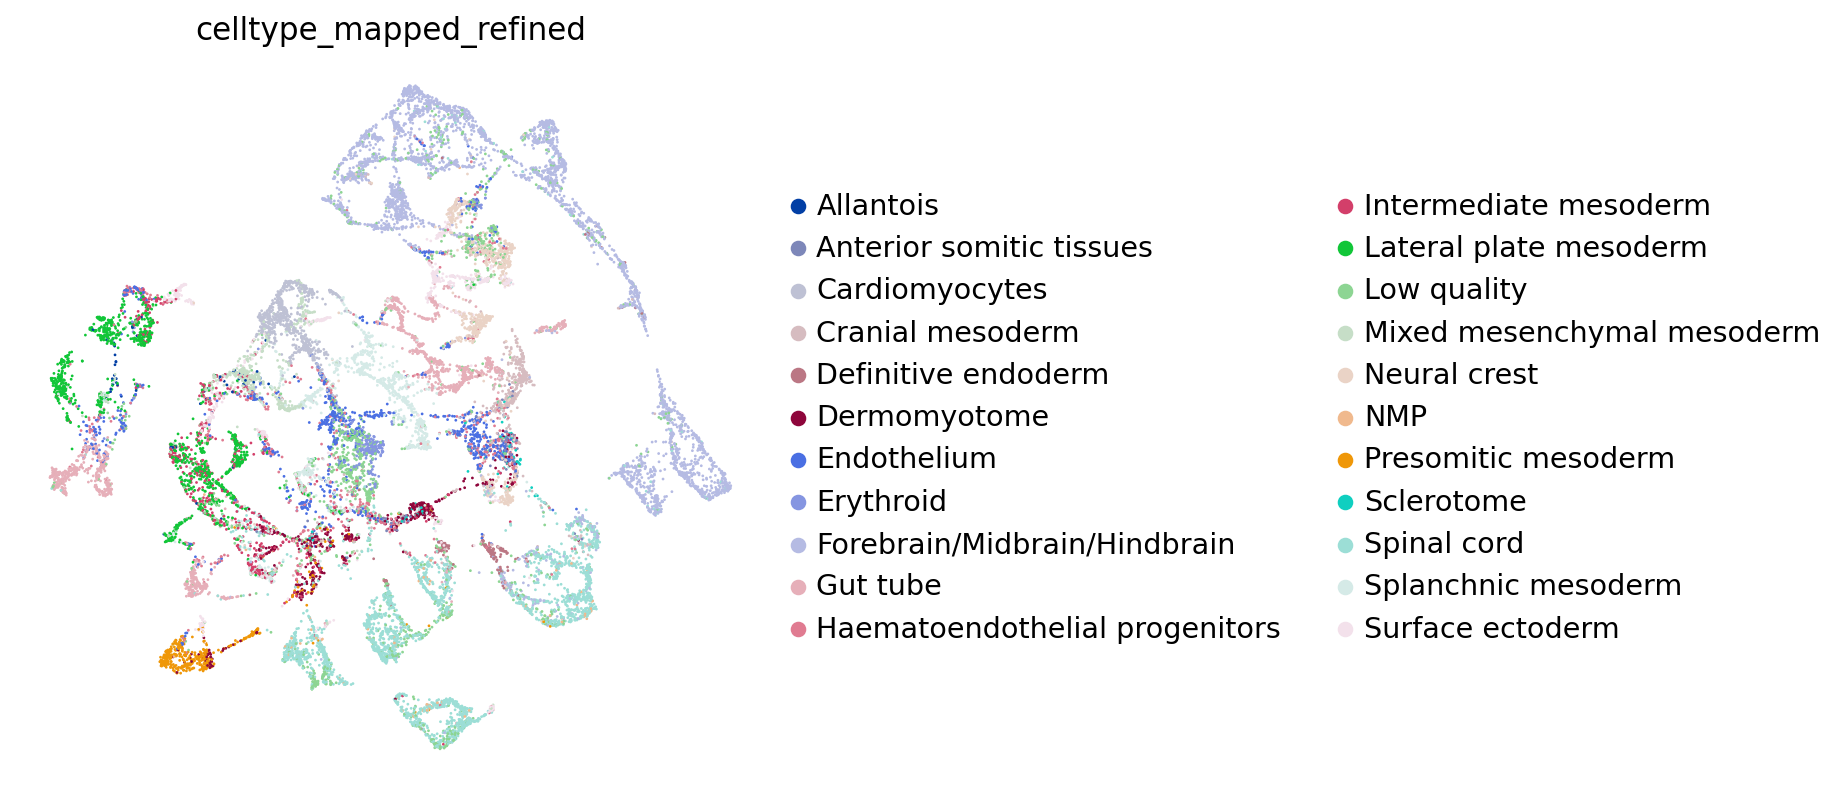

In [15]:
# adata used during model training
latent = model.get_latent_representation()
# New adata
latent_new_data = model.get_latent_representation(adata)
adata.obsm["latent_autotalker_fc_gps"] = latent_new_data

now = datetime.now()
current_time = now.strftime("%d%m%Y_%H%M%S")

sc.set_figure_params(figsize=(6, 6))

# Use autotalker latent space for UMAP generation
sc.pp.neighbors(adata, use_rep="latent_autotalker_fc_gps")
sc.tl.umap(adata, min_dist=0.3)
sc.pl.umap(adata, color=[cell_type_key], frameon=False, save=f"_latent_autotalker_fc_gps_{current_time}.png")

## 4. Autotalker Model with Cell-Cell-Interaction (CCI) Gene Programs

### 4.1 NicheNet CCI Gene Programs

#### 4.1.1 Create NicheNet CCI Gene Program Mask

In [16]:
nichenet_gp_dict = extract_gp_dict_from_nichenet_ligand_target_mx(
    keep_target_ratio=0.1,
    load_from_disk=False,
    save_to_disk=True,
    file_path=nichenet_ligand_target_mx_file_path)

In [17]:
add_gps_from_gp_dict_to_adata(
    adata=adata,
    gp_dict=nichenet_gp_dict,
    genes_uppercase=True,
    gp_targets_varm_key="autotalker_nichenet_gps_targets",
    gp_sources_varm_key="autotalker_nichenet_gps_sources",
    gp_names_uns_key="autotalker_nichenet_gps_names",
    min_genes_per_gp=0,
    max_genes_per_gp=None)

In [18]:
print(f"Number of gene programs: {len(adata.uns['autotalker_nichenet_gps_names'])}.")
print(f"Example gene programs: {adata.uns['autotalker_nichenet_gps_names'][:5]}.")
print(f"Number of gene program target genes: {adata.varm['autotalker_nichenet_gps_targets'].sum()}.")
print(f"Number of gene program source genes: {adata.varm['autotalker_nichenet_gps_sources'].sum()}.")

Number of gene programs: 665.
Example gene programs: ['CXCL1_ligand_targetgenes_GP', 'CXCL2_ligand_targetgenes_GP', 'CXCL3_ligand_targetgenes_GP', 'CXCL5_ligand_targetgenes_GP', 'PPBP_ligand_targetgenes_GP']
Number of gene program target genes: 68235.
Number of gene program source genes: 46.


In [23]:
nichenet_gps_targets_mask = torch.tensor(adata.varm["autotalker_nichenet_gps_targets"].T, dtype=torch.float32)
nichenet_gps_sources_mask = torch.tensor(adata.varm["autotalker_nichenet_gps_sources"].T, dtype=torch.float32)
nichenet_gps_mask = torch.cat((nichenet_gps_targets_mask, nichenet_gps_sources_mask), dim=1)
print(f"Gene program mask shape (gene programs x nodes): {nichenet_gps_mask.shape}.")
nichenet_gps_n_hidden_encoder = int(nichenet_gps_mask.shape[0] / 2)
print(f"Number of hidden layers in the encoder: {nichenet_gps_n_hidden_encoder}.")

Gene program mask shape (gene programs x nodes): torch.Size([665, 702]).
Number of hidden layers in the encoder: 332.


#### 4.1.2 Initialize, Train & Save Model

In [24]:
model = Autotalker(adata,
                   counts_layer_key="counts",
                   adj_key="spatial_connectivities",
                   gp_targets_mask_key="autotalker_nichenet_gps_targets",
                   gp_sources_mask_key="autotalker_nichenet_gps_sources",
                   include_edge_recon_loss=True,
                   include_gene_expr_recon_loss=True,
                   log_variational=True,
                   node_label_method=node_label_method,
                   n_hidden_encoder=nichenet_gps_n_hidden_encoder,
                   dropout_rate_encoder=0.,
                   dropout_rate_graph_decoder=0.,
                   gp_targets_mask=None,
                   gp_sources_mask=None)

--- INITIALIZING NEW NETWORK MODULE: VGPGAE ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True
GCN ENCODER -> n_input: 351, n_hidden: 332, n_latent: 665, dropout_rate: 0.0
DOT PRODUCT GRAPH DECODER -> dropout_rate: 0.0
MASKED GENE EXPRESSION DECODER -> n_input: 665, n_output: 702


In [25]:
experiment = mlflow.set_experiment("autotalker_nichenet_gps")
mlflow.log_param("dataset", dataset)

model.train(n_epochs=30,
            lr=0.01,
            weight_decay=0,
            edge_val_ratio=0.1,
            edge_test_ratio=0.05,
            node_val_ratio=0.1,
            edge_batch_size=edge_batch_size,
            mlflow_experiment_id=experiment.experiment_id)

--- INITIALIZING TRAINER ---
Number of training nodes: 17474
Number of validation nodes: 1942
Number of training edges: 36291
Number of validation edges: 4269
Number of test edges: 2134

--- MODEL TRAINING ---
Epoch 1/30 |--------------------| 3.3% val_auroc_score: 0.9384; val_auprc_score: 0.8988; val_best_acc_score: 0.5772; val_best_f1_score: 0.7028; train_loss: 729.5821; train_edge_recon_loss: 3.5694; train_kl_loss: 0.5811; train_gene_expr_recon_loss: 725.4316; val_loss: 719.0472; val_edge_recon_loss: 2.4566; val_kl_loss: 0.6833; val_gene_expr_recon_loss: 715.9072
Epoch 2/30 |█-------------------| 6.7% val_auroc_score: 0.9493; val_auprc_score: 0.9305; val_best_acc_score: 0.6465; val_best_f1_score: 0.7386; train_loss: 714.6135; train_edge_recon_loss: 2.1933; train_kl_loss: 0.7024; train_gene_expr_recon_loss: 711.7178; val_loss: 718.6565; val_edge_recon_loss: 1.8721; val_kl_loss: 0.6478; val_gene_expr_recon_loss: 716.1366
Epoch 3/30 |██------------------| 10.0% val_auroc_score: 0.9519;

#### 4.1.3 Visualize Latent Gene Programs with scanpy

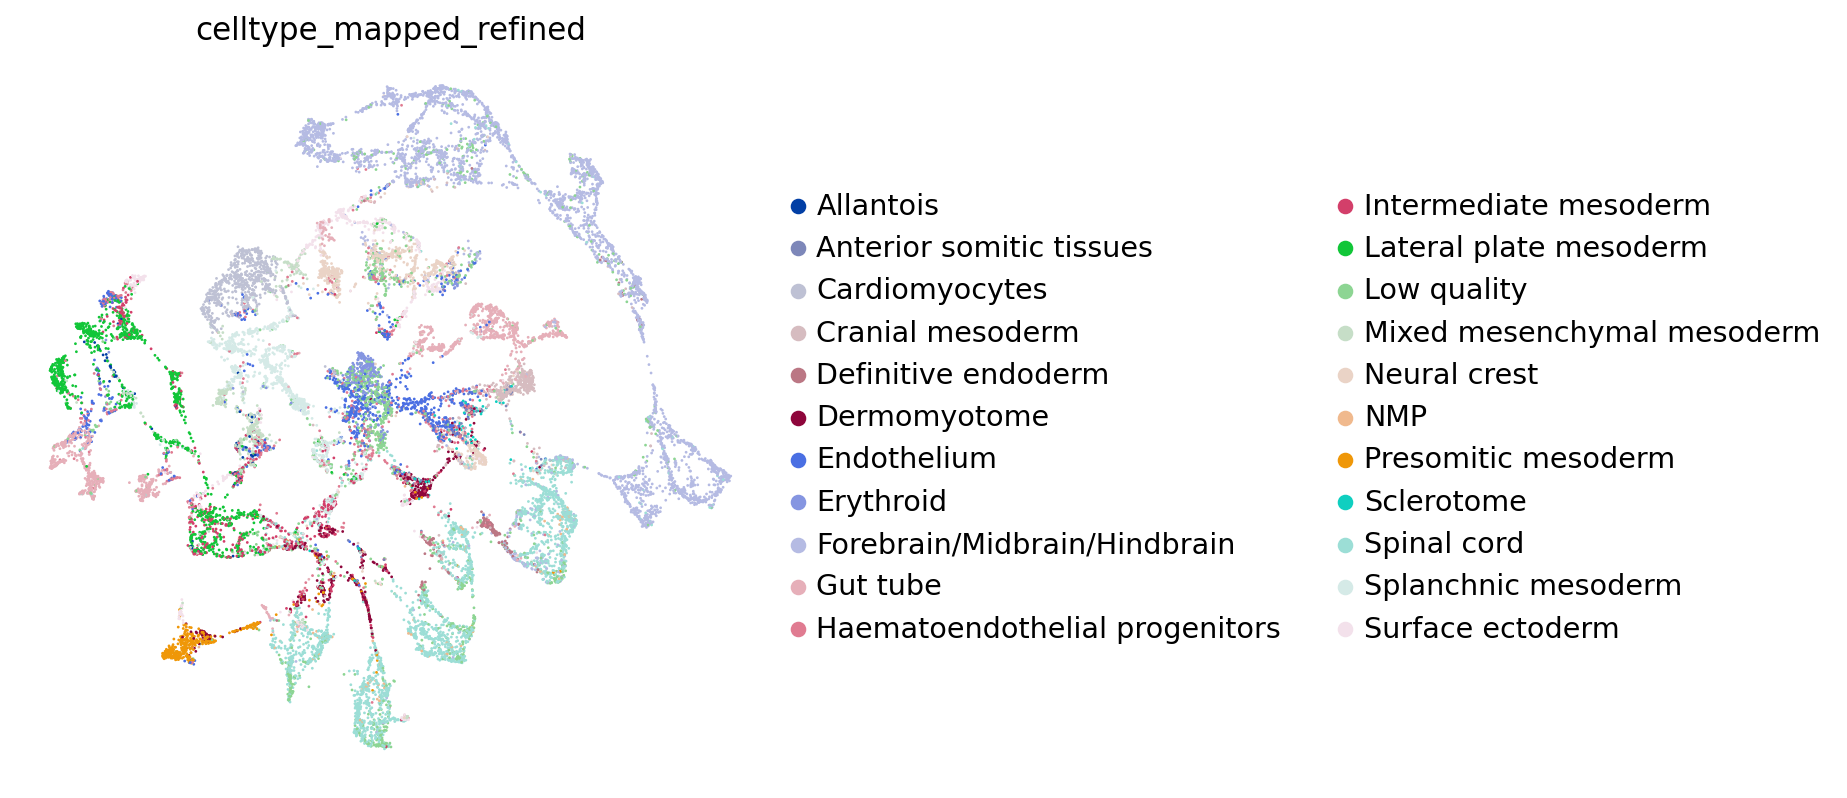

In [26]:
# adata used during model training
latent = model.get_latent_representation()
# New adata
latent_new_data = model.get_latent_representation(adata)
adata.obsm["latent_autotalker_nichenet_gps"] = latent_new_data

now = datetime.now()
current_time = now.strftime("%d%m%Y_%H%M%S")

sc.set_figure_params(figsize=(6, 6))

# Use autotalker latent space for UMAP generation
sc.pp.neighbors(adata, use_rep="latent_autotalker_nichenet_gps")
sc.tl.umap(adata, min_dist=0.3)
sc.pl.umap(adata, color=[cell_type_key], frameon=False, save=f"_latent_autotalker_nichenet_gps_{current_time}.png")

### 4.2 OmniPath CCI Gene Programs

#### 4.2.1 Create OmniPath CCI Gene Program Mask

In [27]:
omnipath_gp_dict = extract_gp_dict_from_omnipath_lr_interactions(
    min_curation_effort=0,
    load_from_disk=False,
    save_to_disk=True,
    file_path=omnipath_lr_interactions_file_path)

In [28]:
add_gps_from_gp_dict_to_adata(
    adata=adata,
    gp_dict=omnipath_gp_dict,
    genes_uppercase=True,
    gp_targets_varm_key="autotalker_omnipath_gps_targets",
    gp_sources_varm_key="autotalker_omnipath_gps_sources",
    gp_names_uns_key="autotalker_omnipath_gps_names",
    min_genes_per_gp=0,
    max_genes_per_gp=None)

In [31]:
print(f"Number of gene programs: {len(adata.uns['autotalker_omnipath_gps_names'])}.")
print(f"Example gene programs: {adata.uns['autotalker_omnipath_gps_names'][:5]}.")
print(f"Number of gene program target genes: {adata.varm['autotalker_omnipath_gps_targets'].sum()}.")
print(f"Number of gene program source genes: {adata.varm['autotalker_omnipath_gps_sources'].sum()}.")

Number of gene programs: 104.
Example gene programs: ['EPOR_ligand_receptor_GP', 'KL_ligand_receptor_GP', 'TP53_ligand_receptor_GP', 'CXCL12_ligand_receptor_GP', 'NTN1_ligand_receptor_GP'].
Number of gene program target genes: 50.
Number of gene program source genes: 59.


In [32]:
omnipath_gps_targets_mask = torch.tensor(adata.varm["autotalker_omnipath_gps_targets"].T, dtype=torch.float32)
omnipath_gps_sources_mask = torch.tensor(adata.varm["autotalker_omnipath_gps_sources"].T, dtype=torch.float32)
omnipath_gps_mask = torch.cat((omnipath_gps_targets_mask, omnipath_gps_sources_mask), dim=1)
print(f"Gene program mask shape (gene programs x nodes): {omnipath_gps_mask.shape}.")
omnipath_gps_n_hidden_encoder = int(omnipath_gps_mask.shape[0] / 2)
print(f"Number of hidden layers in the encoder: {omnipath_gps_n_hidden_encoder}.")

Gene program mask shape (gene programs x nodes): torch.Size([104, 702]).
Number of hidden layers in the encoder: 52.


#### 4.2.2 Initialize, Train & Save Model

In [33]:
model = Autotalker(adata,
                   counts_layer_key="counts",
                   adj_key="spatial_connectivities",
                   gp_targets_mask_key="autotalker_omnipath_gps_targets",
                   gp_sources_mask_key="autotalker_omnipath_gps_sources",
                   include_edge_recon_loss=True,
                   include_gene_expr_recon_loss=True,
                   log_variational=True,
                   node_label_method=node_label_method,
                   n_hidden_encoder=omnipath_gps_n_hidden_encoder,
                   dropout_rate_encoder=0.,
                   dropout_rate_graph_decoder=0.,
                   gp_targets_mask=None,
                   gp_sources_mask=None)

--- INITIALIZING NEW NETWORK MODULE: VGPGAE ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True
GCN ENCODER -> n_input: 351, n_hidden: 52, n_latent: 104, dropout_rate: 0.0
DOT PRODUCT GRAPH DECODER -> dropout_rate: 0.0
MASKED GENE EXPRESSION DECODER -> n_input: 104, n_output: 702


In [34]:
experiment = mlflow.set_experiment("autotalker_omnipath_gps")
mlflow.log_param("dataset", dataset)

model.train(n_epochs=30,
            lr=0.01,
            weight_decay=0,
            edge_val_ratio=0.1,
            edge_test_ratio=0.05,
            node_val_ratio=0.1,
            edge_batch_size=edge_batch_size,
            mlflow_experiment_id=experiment.experiment_id)

--- INITIALIZING TRAINER ---
Number of training nodes: 17474
Number of validation nodes: 1942
Number of training edges: 36291
Number of validation edges: 4269
Number of test edges: 2134

--- MODEL TRAINING ---
Epoch 1/30 |--------------------| 3.3% val_auroc_score: 0.7800; val_auprc_score: 0.7640; val_best_acc_score: 0.5234; val_best_f1_score: 0.6769; train_loss: 799.3690; train_edge_recon_loss: 3.6435; train_kl_loss: 0.1494; train_gene_expr_recon_loss: 795.5761; val_loss: 790.1416; val_edge_recon_loss: 2.5241; val_kl_loss: 0.1849; val_gene_expr_recon_loss: 787.4326
Epoch 2/30 |█-------------------| 6.7% val_auroc_score: 0.7511; val_auprc_score: 0.7553; val_best_acc_score: 0.5294; val_best_f1_score: 0.6789; train_loss: 784.5996; train_edge_recon_loss: 2.4404; train_kl_loss: 0.1812; train_gene_expr_recon_loss: 781.9781; val_loss: 789.4949; val_edge_recon_loss: 2.0819; val_kl_loss: 0.1763; val_gene_expr_recon_loss: 787.2367
Epoch 3/30 |██------------------| 10.0% val_auroc_score: 0.7789;

#### 4.2.3 Visualize Latent Gene Programs with scanpy

In [ ]:
# adata used during model training
latent = model.get_latent_representation()
# New adata
latent_new_data = model.get_latent_representation(adata)
adata.obsm["latent_autotalker_omnipath_gps"] = latent_new_data

now = datetime.now()
current_time = now.strftime("%d%m%Y_%H%M%S")

sc.set_figure_params(figsize=(6, 6))

# Use autotalker latent space for UMAP generation
sc.pp.neighbors(adata, use_rep="latent_autotalker_omnipath_gps")
sc.tl.umap(adata, min_dist=0.3)
sc.pl.umap(adata, color=[cell_type_key], frameon=False, save=f"_latent_autotalker_omnipath_gps_{current_time}.png")

### 4.3 NicheNet & OmniPath CCI Gene Programs Combined

#### 4.3.1 Create Combined Gene Program Mask

In [35]:
combined_gp_dict = dict(nichenet_gp_dict)
combined_gp_dict.update(omnipath_gp_dict)

In [36]:
add_gps_from_gp_dict_to_adata(
    adata=adata,
    gp_dict=combined_gp_dict,
    genes_uppercase=True,
    gp_targets_varm_key="autotalker_combined_gps_targets",
    gp_sources_varm_key="autotalker_combined_gps_sources",
    gp_names_uns_key="autotalker_combined_gps_names",
    min_genes_per_gp=0,
    max_genes_per_gp=None)

In [37]:
print(f"Number of gene programs: {len(adata.uns['autotalker_combined_gps_names'])}.")
print(f"Example gene programs: {adata.uns['autotalker_combined_gps_names'][:5]}.")
print(f"Number of gene program target genes: {adata.varm['autotalker_combined_gps_targets'].sum()}.")
print(f"Number of gene program source genes: {adata.varm['autotalker_combined_gps_sources'].sum()}.")

Number of gene programs: 769.
Example gene programs: ['CXCL1_ligand_targetgenes_GP', 'CXCL2_ligand_targetgenes_GP', 'CXCL3_ligand_targetgenes_GP', 'CXCL5_ligand_targetgenes_GP', 'PPBP_ligand_targetgenes_GP'].
Number of gene program target genes: 68285.
Number of gene program source genes: 105.


In [38]:
combined_gps_targets_mask = torch.tensor(adata.varm["autotalker_combined_gps_targets"].T, dtype=torch.float32)
combined_gps_sources_mask = torch.tensor(adata.varm["autotalker_combined_gps_sources"].T, dtype=torch.float32)
combined_gps_mask = torch.cat((combined_gps_targets_mask, combined_gps_sources_mask), dim=1)
print(f"Gene program mask shape (gene programs x nodes): {combined_gps_mask.shape}.")
combined_gps_n_hidden_encoder = int(combined_gps_mask.shape[0] / 2)
print(f"Number of hidden layers in the encoder: {combined_gps_n_hidden_encoder}.")

Gene program mask shape (gene programs x nodes): torch.Size([769, 702]).
Number of hidden layers in the encoder: 384.


#### 4.3.2 Initialize, Train & Save Model

In [39]:
model = Autotalker(adata,
                   counts_layer_key="counts",
                   adj_key="spatial_connectivities",
                   gp_targets_mask_key="autotalker_combined_gps_targets",
                   gp_sources_mask_key="autotalker_combined_gps_sources",
                   include_edge_recon_loss=True,
                   include_gene_expr_recon_loss=True,
                   log_variational=True,
                   node_label_method=node_label_method,
                   n_hidden_encoder=combined_gps_n_hidden_encoder,
                   dropout_rate_encoder=0.,
                   dropout_rate_graph_decoder=0.,
                   gp_targets_mask=None,
                   gp_sources_mask=None)

--- INITIALIZING NEW NETWORK MODULE: VGPGAE ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True
GCN ENCODER -> n_input: 351, n_hidden: 384, n_latent: 769, dropout_rate: 0.0
DOT PRODUCT GRAPH DECODER -> dropout_rate: 0.0
MASKED GENE EXPRESSION DECODER -> n_input: 769, n_output: 702


In [40]:
experiment = mlflow.set_experiment("autotalker_combined_gps")
mlflow.log_param("dataset", dataset)

model.train(n_epochs=30,
            lr=0.01,
            weight_decay=0,
            edge_val_ratio=0.1,
            edge_test_ratio=0.05,
            node_val_ratio=0.1,
            edge_batch_size=32,
            grad_clip_value=5,
            mlflow_experiment_id=None)

--- INITIALIZING TRAINER ---
Number of training nodes: 17474
Number of validation nodes: 1942
Number of training edges: 36291
Number of validation edges: 4269
Number of test edges: 2134

--- MODEL TRAINING ---
Epoch 1/30 |--------------------| 3.3% val_auroc_score: 0.8626; val_auprc_score: 0.7856; val_best_acc_score: 0.5520; val_best_f1_score: 0.6906; train_loss: 722.6936; train_edge_recon_loss: 4.9361; train_kl_loss: 0.6458; train_gene_expr_recon_loss: 717.1117; val_loss: 710.8323; val_edge_recon_loss: 3.3956; val_kl_loss: 0.7136; val_gene_expr_recon_loss: 706.7231
Epoch 2/30 |█-------------------| 6.7% val_auroc_score: 0.9268; val_auprc_score: 0.8783; val_best_acc_score: 0.5863; val_best_f1_score: 0.7073; train_loss: 705.0314; train_edge_recon_loss: 2.9585; train_kl_loss: 0.8068; train_gene_expr_recon_loss: 701.2661; val_loss: 708.6231; val_edge_recon_loss: 2.5751; val_kl_loss: 0.7658; val_gene_expr_recon_loss: 705.2822
Epoch 3/30 |██------------------| 10.0% val_auroc_score: 0.9520;

#### 4.3.3 Visualize Latent Gene Programs with scanpy

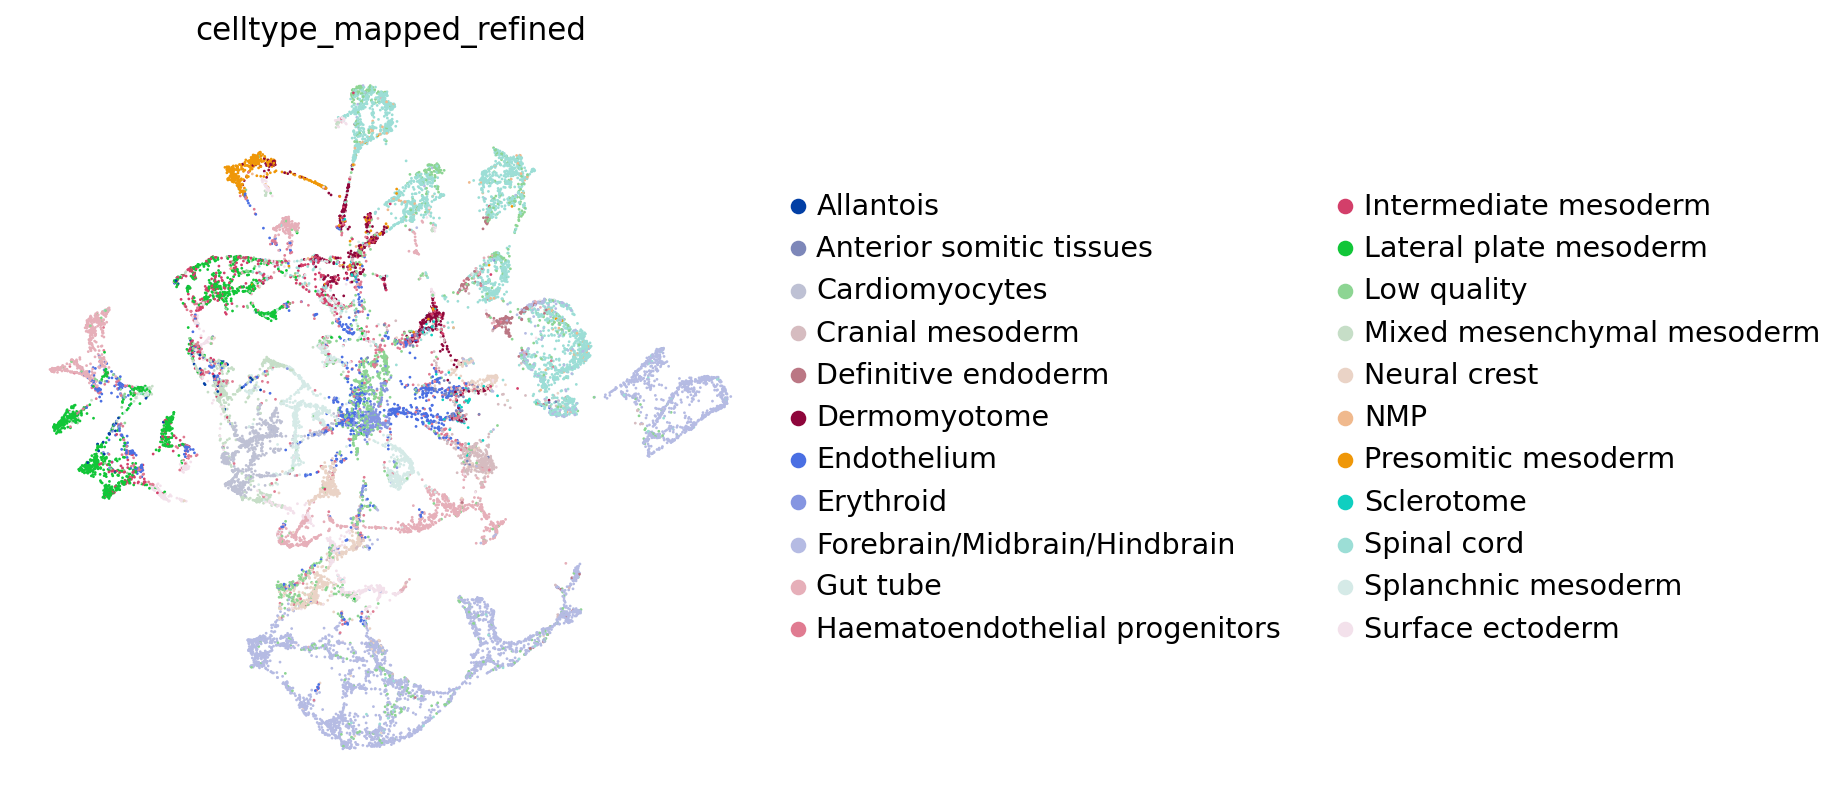

In [41]:
# adata used during model training
latent = model.get_latent_representation()
# New adata
latent_new_data = model.get_latent_representation(adata)
adata.obsm["latent_autotalker_combined_gps"] = latent_new_data

now = datetime.now()
current_time = now.strftime("%d%m%Y_%H%M%S")

sc.set_figure_params(figsize=(6, 6))

# Use autotalker latent space for UMAP generation
sc.pp.neighbors(adata, use_rep="latent_autotalker_combined_gps")
sc.tl.umap(adata, min_dist=0.3)
sc.pl.umap(adata, color=[cell_type_key], frameon=False, save=f"_latent_autotalker_combined_gps_{current_time}.png")

The model can maintain the edge reconstruction performance while tweaking the latent space for better gene expression reconstruction.

In [42]:
gene_programs = adata.uns["autotalker_combined_gps_names"]

In [49]:
gene_programs = adata.uns["autotalker_combined_gps_names"]
selected_gene_programs = ["CSF1_ligand_targetgenes_GP", "IL34_ligand_targetgenes_GP"]
selected_gene_programs_idx = [gene_programs.index(gene_program) for gene_program in selected_gene_programs]

In [50]:
latent_selected_gps = latent[:, selected_gene_programs_idx]

In [51]:
adata.obs["CSF1_ligand_targetgenes_GP"] = latent_selected_gps[:, 0]
adata.obs["IL34_ligand_targetgenes_GP"] = latent_selected_gps[:, 1]

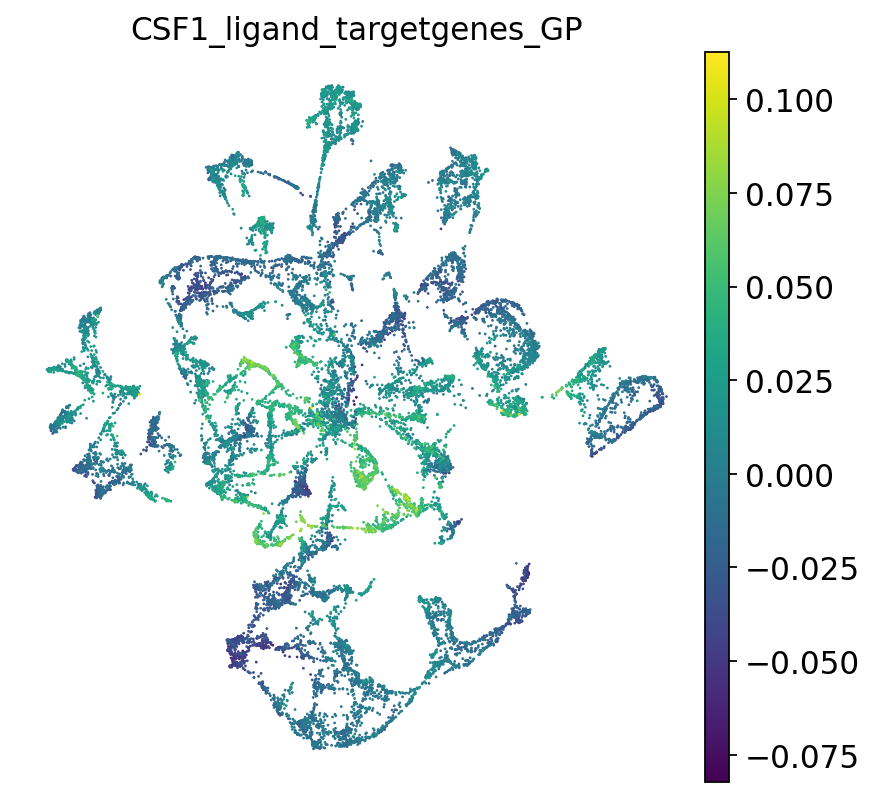

In [52]:
sc.pl.umap(adata, color="CSF1_ligand_targetgenes_GP", frameon=False, wspace=0.6)

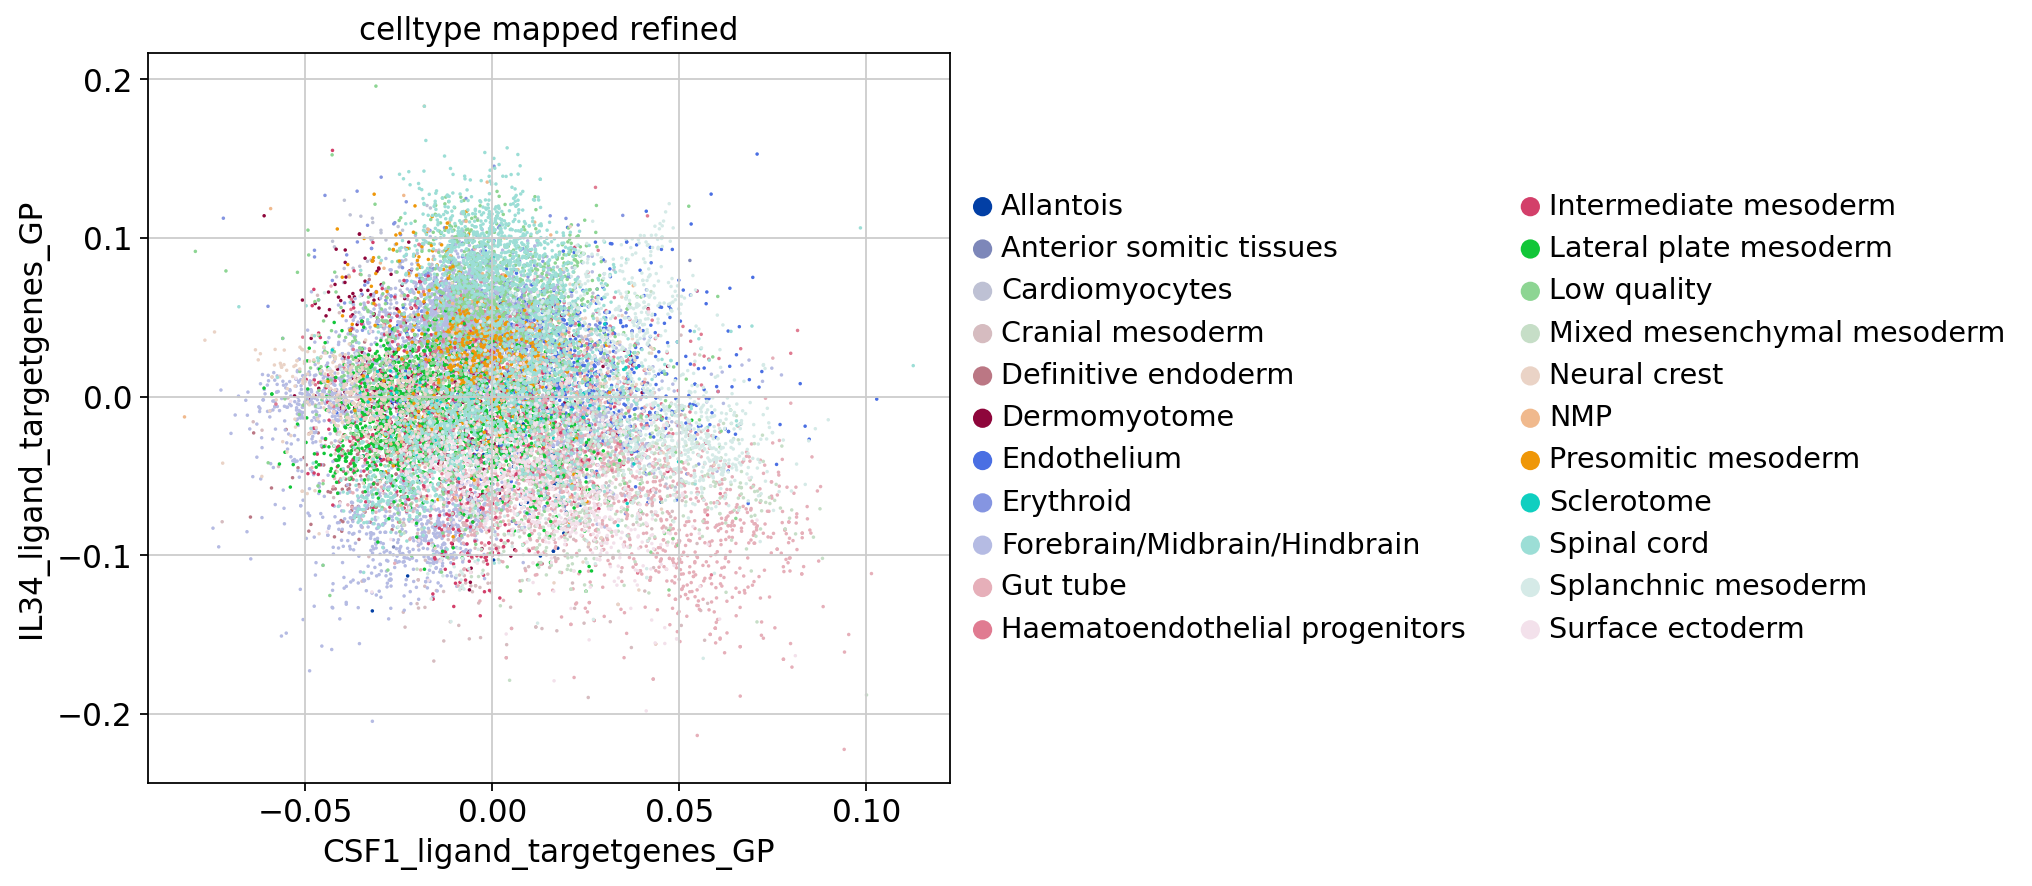

In [53]:
sc.pl.scatter(adata, x="CSF1_ligand_targetgenes_GP", y="IL34_ligand_targetgenes_GP", color=cell_type_key, size=10)

### 5. Comparison SCVI Model

In [ ]:
import scvi
import scanpy as sc
import matplotlib.pyplot as plt

sc.set_figure_params(figsize=(6, 6))

# for white background of figures (only for docs rendering)
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

In [ ]:
adata.layers["counts"] = adata.X.copy() # preserve counts
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata # freeze the state in `.raw`

In [ ]:
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts"
)

In [ ]:
model = scvi.model.SCVI(adata)

In [ ]:
model

In [ ]:
model.train()

In [ ]:
latent_scvi = model.get_latent_representation()

In [ ]:
adata.obsm["X_scVI"] = latent_scvi

In [ ]:
# run PCA then generate UMAP plots
sc.tl.pca(adata)
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.3)

In [ ]:
sc.pl.umap(adata, color=["celltype_mapped_refined"], frameon=False,)